In [10]:
import os
import time
import pandas as pd
import pigeonXT as pixt
from ipywidgets import IntProgress, HBox, Label
from IPython.display import display, Image as IPythonImage
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *
from PIL import Image as PyImage

PyImage.MAX_IMAGE_PIXELS = None


In [2]:
# item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
# batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
# bs=16
# path = Path('./data/train')

# docs = DataBlock(blocks=(ImageBlock, CategoryBlock),
#                  get_items=get_image_files,
#                  splitter=RandomSplitter(),
#                  get_y=parent_label,
#                  item_tfms=item_tfms,
#                  batch_tfms=batch_tfms)

# dls = docs.dataloaders(path, bs=bs)

# dls.show_batch(max_n=9, figsize=(6,7))
# learn = cnn_learner(dls, resnet34, pretrained=True, metrics=error_rate)

In [2]:
source = Path('data/')
df = pd.read_csv(source/'train.csv')
df

,path,labels
0,f7c3eaf2-29dc-4b75-8850-551618eaeefd-13.png,document
1,b16b5d58-f3ea-4e21-98d2-1248d1a36b22-2.png,document
2,00dd549e-9432-4e64-a49e-80b1c8dd39dc-05.png,document
3,39a37e5d-501d-4dc7-9e31-635f6c4441f7-3.png,invoice
4,a30b7b10-76f2-4c9a-b18d-3374305e0b0b-12.png,document
...,...,...
653,6050abd64e7aa_schippa_nouvelle_carte_identite-5232826.jpg,fr-id2021-recto
654,RZXHDNH2U7WLOG747M3OUJRR3E.jpg,fr-id2021-recto fr-id2021-verso
655,B9727025403Z.1_20210513185635_000+GF1I4F0KQ.1-0.png,fr-id2021-recto fr-id2021-verso
656,image-11-1-770x540.png,fr-id2021-recto fr-id2021-verso


In [3]:
item_tfms = Resize(460, method=ResizeMethod.Squish)
# RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
# batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
batch_tfms = aug_transforms(mult=1.0, do_flip=True, flip_vert=True, max_rotate=360.0, min_zoom=0.8, max_zoom=1.2, max_lighting=0.2, max_warp=0.3, p_affine=0.75, p_lighting=0.75, xtra_tfms=None, size=None, mode='bilinear', pad_mode='zeros', align_corners=True, batch=False, min_scale=1.0)
docs = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=f'{source}/train/'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms=item_tfms,
                   batch_tfms = batch_tfms)

In [4]:
dls = docs.dataloaders(df, bs=16)

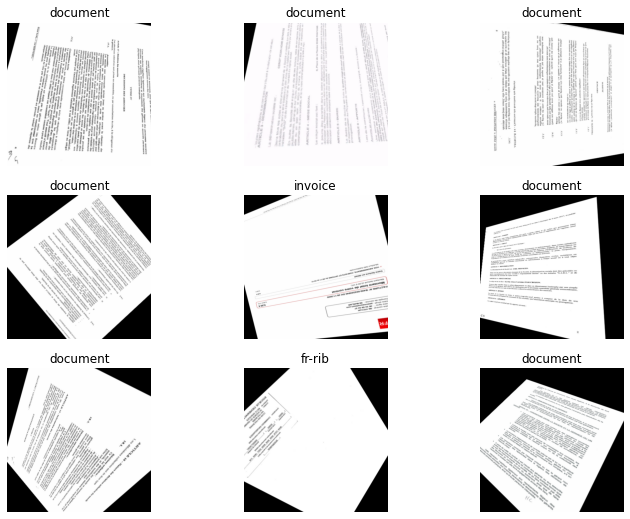

In [5]:
dls.show_batch(max_n=9, figsize=(12,9))

In [7]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=[accuracy_multi])

In [8]:
learn.loss_func = BCEWithLogitsLossFlat()

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.0691830962896347)

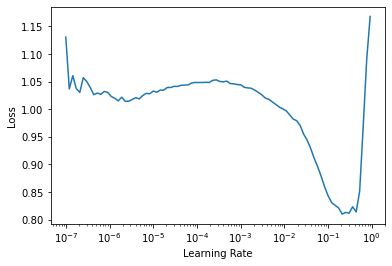

In [9]:
learn.lr_find()

In [10]:
lr = 0.02089296132326126
learn = learn.to_fp16()

In [11]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.718005,0.207395,0.939780,00:24
1,0.351882,0.125751,0.961832,00:23
2,0.226470,0.095706,0.974555,00:23
3,0.155190,0.072447,0.972858,00:24
4,0.115474,0.074800,0.971162,00:24


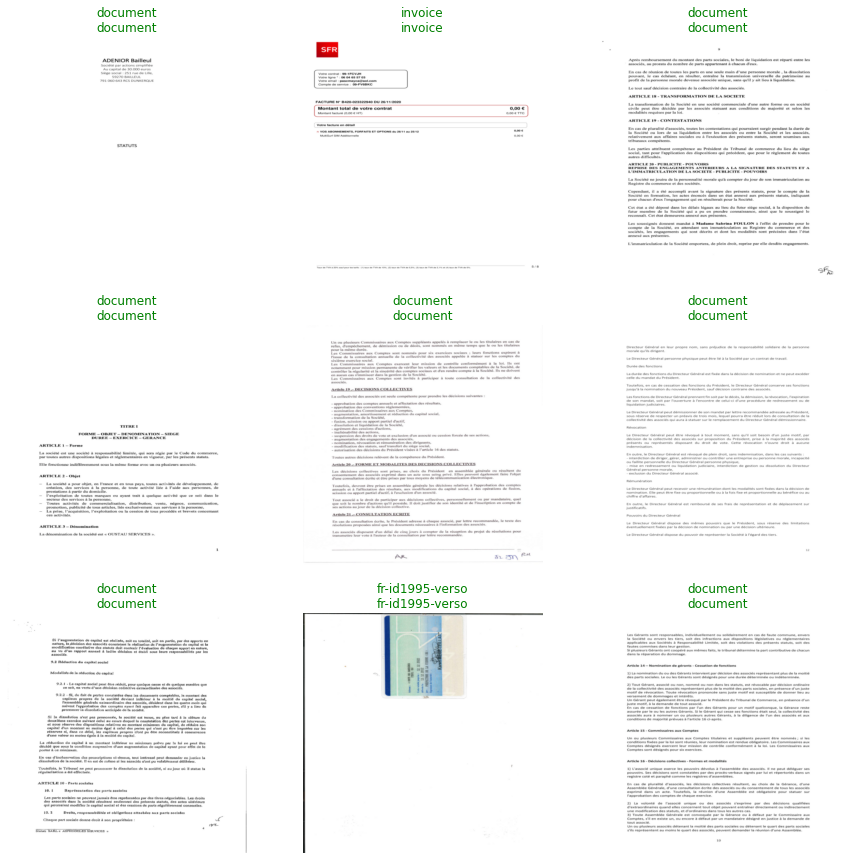

In [12]:
learn.show_results(figsize=(15,15))

In [13]:
learn.save('model')

Path('models/model.pth')

In [14]:
learn.load('model')

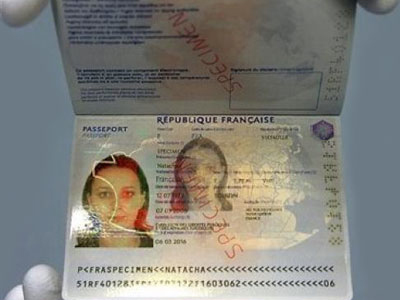

In [15]:
image = Path(source/'test/Passeport.jpg')
i=load_image(image)
i

In [44]:
learn.predict(image)

((#1) ['fr-passport'],
 tensor([False, False, False, False, False, False,  True, False, False]),
 tensor([8.4784e-03, 3.5399e-01, 8.0502e-02, 3.7536e-01, 2.7348e-01, 7.0863e-05,
         9.3071e-01, 4.4076e-04, 8.7114e-03]))

In [38]:
learn.dls.vocab

['document', 'fr-id1995-recto', 'fr-id1995-verso', 'fr-id2021-recto', 'fr-id2021-verso', 'fr-kbis', 'fr-passport', 'fr-rib', 'invoice']